In [1]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
import dotenv
from langchain_openai import OpenAIEmbeddings

dotenv.load_dotenv()
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

pc =Pinecone()

index_name = "tax-index-langgraph"

index = pc.Index(index_name)
vectorstore = PineconeVectorStore(embedding=embedding, index=index)


retriever = vectorstore.as_retriever(search_kwargs={'k':3})

C:\Users\soobi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Annotated
from typing_extensions import List, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.documents import Document
import operator

class AgentState(TypedDict) :
    query:str
    context: Annotated[List[Document], operator.add]
    answer:str

In [3]:
from langgraph.graph import StateGraph

graph_builer = StateGraph(AgentState)

In [4]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt")

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini')

In [6]:
#node:retrieve, generate 노트

def retrieveDoc(state:AgentState) ->AgentState:
    query=state['query']
    docs =retriever.invoke(query)
    return {'context':docs}

In [7]:
def generateAnswer(state:AgentState)->AgentState:
    context= state['context']
    query= state['query']
    lag_chain = generate_prompt | llm
    response = lag_chain.invoke({'question':query, 'context': context})

    return {'answer': response}

In [8]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client
from typing import Literal

client = Client()
relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState)-> Literal['generateAnswer','rewrite']:
    query= state['query']
    context= state['context']
   
    relevance_chain = relevance_prompt | llm
    response = relevance_chain.invoke({'question':query, 'documents': context})

   
    if response['Score'] ==1:
        return 'generateAnswer'
    
    return 'rewrite'

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_propmt = PromptTemplate.from_template(f"""사용자의 질문을 보고,
우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전:{dictionary}
질문: {{query}}""")

def rewrite(state: AgentState)->AgentState:
    query = state['query']
    rewrite_chain = rewrite_propmt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query' : response}




In [10]:
graph_builer.add_node('retrieveDoc', retrieveDoc)

graph_builer.add_node('generateAnswer', generateAnswer)
graph_builer.add_node('rewrite', rewrite)


In [11]:
from langgraph.graph import START, END

graph_builer.add_edge(START,'retrieveDoc')
graph_builer.add_conditional_edges('retrieveDoc', check_doc_relevance)
graph_builer.add_edge('rewrite','retrieveDoc')
graph_builer.add_edge('generateAnswer', END)


In [12]:
graph =graph_builer.compile()

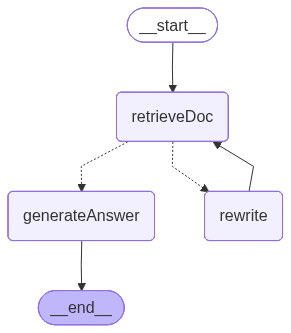

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_State = {'query' : '연봉 5천만원 세금'}
graph.invoke(initial_State)

{'query': '연봉 5천만원 세금',
 'context': [Document(id='15f6746f-4e63-4775-a47e-c72298375620', metadata={'source': './tax_combined_final.txt'}, page_content='소득세법'),
  Document(id='a6c9015f-092f-4aa3-819b-e23588bb0a0f', metadata={'source': './tax_combined_final.txt'}, page_content='소득세법\n하는 자(제119조제9호에 따른 국내원천 부동산등양도소득을 지급하는 거주자 및 비거주자는 제외한다)는 제127조\n에도 불구하고 그 소득을 지급할 때에 다음 각 호의 금액을 그 비거주자의 국내원천소득에 대한 소득세로서 원천징\n수하여 그 원천징수한 날이 속하는 달의 다음 달 10일까지 대통령령으로 정하는 바에 따라 원천징수 관할 세무서,\n한국은행 또는 체신관서에 납부하여야 한다. <개정 2013. 1. 1., 2016. 12. 20., 2018. 12. 31., 2019. 12. 31., 2020. 12.\n29.>\n1. 제119조제1호에 따른 국내원천 이자소득: 다음 각 목의 구분에 따른 금액\n가. 국가·지방자치단체 및 내국법인이 발행하는 채권에서 발생하는 이자소득: 지급금액의 100분의 14\n나. 가목 외의 이자소득: 지급금액의 100분의 20\n2. 제119조제2호에 따른 국내원천 배당소득: 지급금액의 100분의 20\n3. 제119조제4호에 따른 국내원천 선박등임대소득 및 같은 조 제5호(조세조약에 따라 국내원천 사업소득으로 과세\n할 수 있는 소득은 제외한다)에 따른 국내원천 사업소득: 지급금액의 100분의 2\n4. 제119조제6호에 따른 국내원천 인적용역소득: 지급금액의 100분의 20. 다만, 국외에서 제공하는 인적용역 중대\n통령령으로 정하는 용역을 제공함으로써 발생하는 소득이 조세조약에 따라 국내에서 발생하는 것으로 보는 소득\n에 대해서